## Notebook Roadmap
1. Runtime & dependency setup for Colab
2. Dataset download helpers (Kaggle CLI compatible)
3. Data loading, cleaning, and exploratory analysis
4. Preprocessing and stratified train/validation/test split
5. Neural network model training (3 variants) with early stopping + checkpoints
6. Tree & classical baselines (logistic regression, random forest, gradient boosting, XGBoost)
7. Evaluation: metrics, confusion matrices, ROC curves, learning curves
8. Consolidated results table & best model snapshot

## 1. Runtime Setup for Google Colab
- Installs required packages with `%pip` (TensorFlow, scikit-learn, seaborn, etc.).
- Optionally mounts Google Drive to persist artifacts like model checkpoints.

In [1]:
# ⚙️ Install / upgrade core dependencies (rerun on fresh Colab sessions)
%pip install -q pandas numpy seaborn matplotlib scikit-learn tensorflow kagglehub

In [ ]:
# ⚙️ Optional: mount Google Drive if you want to persist checkpoints/results
# from google.colab import drive
# drive.mount('/content/drive')

## 2. Dataset Download (simple workflow)
Choose one of the two easy options below and run the matching cell:
1. **Quick download with KaggleHub** – no API token required for most public datasets.
2. **Manual upload** – download `heart.csv` yourself and upload it when prompted.
Either option leaves the file in `data/heart.csv`, so everything after this section stays the same.

# Option A: download automatically with KaggleHub (recommended)


In [2]:
# Option A: download automatically with KaggleHub (recommended)
import kagglehub
from pathlib import Path

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
CSV_PATH = DATA_DIR / "heart.csv"

print("Fetching latest dataset via KaggleHub…")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")
source_csv = Path(path) / "heart_disease_uci.csv"
if not source_csv.exists():
    raise FileNotFoundError("heart_disease_uci.csv was not found in the KaggleHub download. Check the dataset contents.")
CSV_PATH.write_bytes(source_csv.read_bytes())
print("Saved dataset to", CSV_PATH.resolve())

Fetching latest dataset via KaggleHub…
Using Colab cache for faster access to the 'heart-disease-data' dataset.
Saved dataset to /content/data/heart.csv


# Option B: manual upload (use if KaggleHub is unavailable)

In [ ]:
# Option B: manual upload (use if KaggleHub is unavailable)
from pathlib import Path
from google.colab import files  # type: ignore

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
CSV_PATH = DATA_DIR / "heart.csv"

print("Please choose the downloaded heart.csv file from Kaggle when prompted.")
uploaded = files.upload()
if "heart.csv" not in uploaded:
    raise FileNotFoundError("heart.csv not uploaded. Please rerun the cell and select the file.")
CSV_PATH.write_bytes(uploaded["heart.csv"])
print("Saved uploaded heart.csv to", CSV_PATH.resolve())

### 3. Imports & Global Configuration

In [3]:
import math
import os
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, f1_score, log_loss, precision_score, recall_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from xgboost import XGBClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
sns.set_theme(style='whitegrid', palette='deep')

### Load Dataset

In [4]:
CSV_PATH = Path('data/heart.csv')
df_raw = pd.read_csv(CSV_PATH)
df_raw.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [5]:
print(f'Shape: {df_raw.shape}')
df_raw.info()

Shape: (920, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [6]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
num,920.0,0.995652,1.142693,0.0,0.00,1.0,2.00,4.0


## 4. Data Cleaning

In [7]:
missing_counts = df_raw.isna().sum()
missing_counts[missing_counts > 0]

,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55
exang,55
oldpeak,62
slope,309
ca,611
thal,486


In [8]:
duplicate_count = df_raw.duplicated().sum()
print(f'Duplicates detected: {duplicate_count}')
df = df_raw.drop_duplicates().reset_index(drop=True)
print(f'Cleaned shape: {df.shape}')

Duplicates detected: 0
Cleaned shape: (920, 16)


## 5. Exploratory Data Analysis

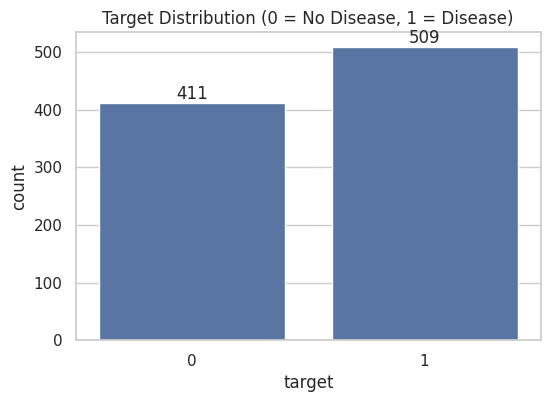

In [9]:
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(data=df, x='target', ax=ax)
ax.set_title('Target Distribution (0 = No Disease, 1 = Disease)')
ax.bar_label(ax.containers[0])
plt.show()

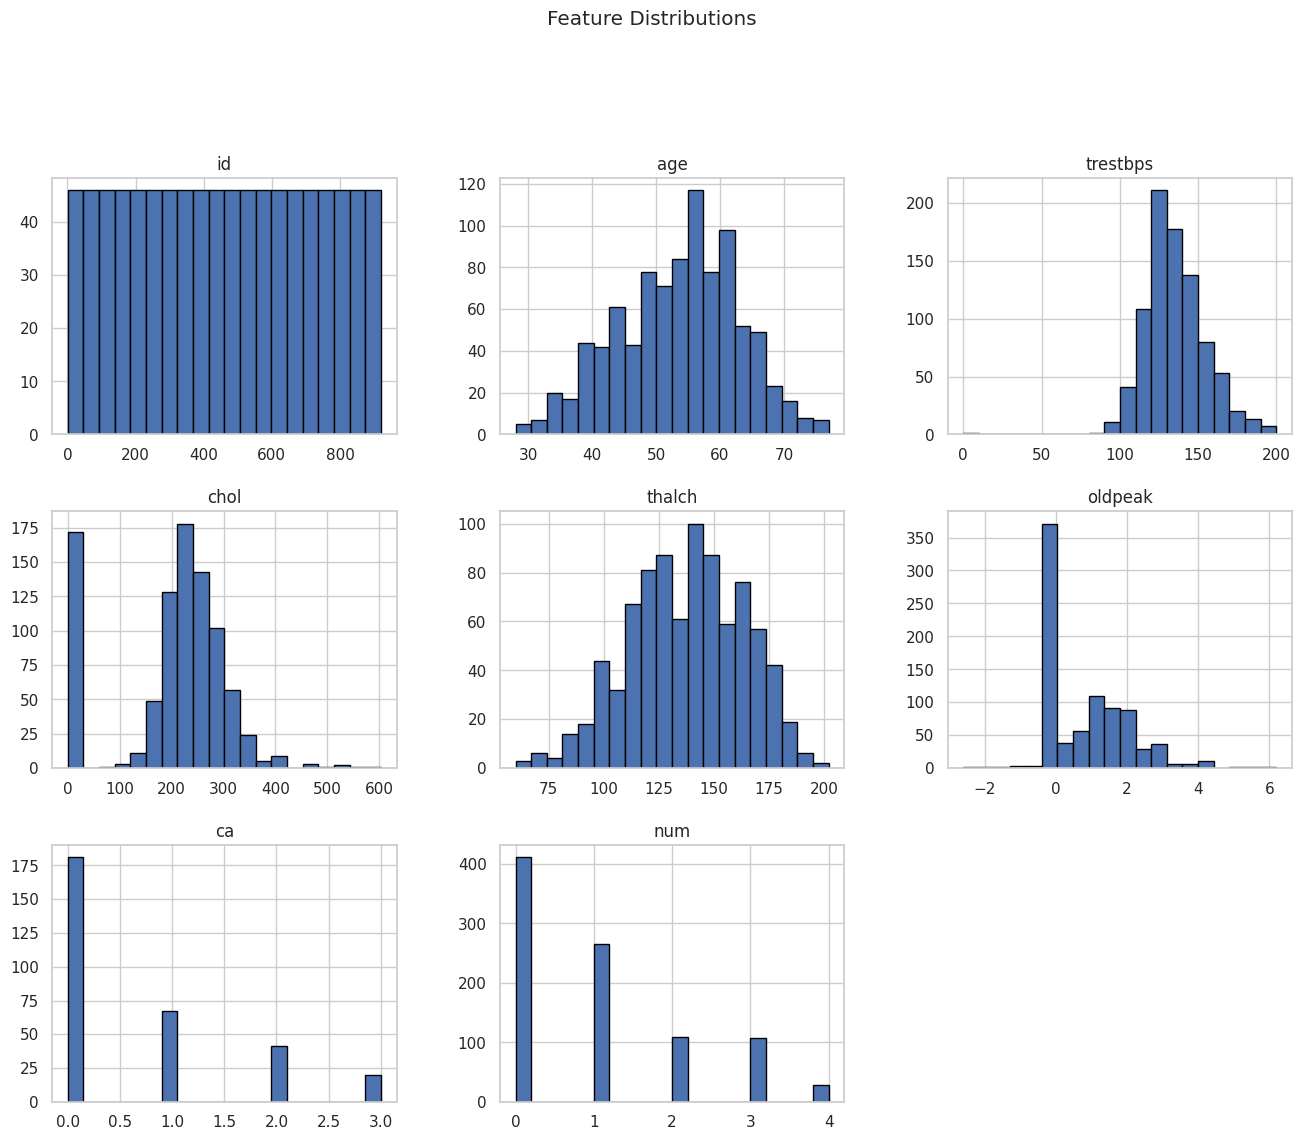

In [10]:
numerical_cols = [col for col in df.columns if col != 'target']
df[numerical_cols].hist(figsize=(16, 12), bins=20, edgecolor='black')
plt.suptitle('Feature Distributions', y=1.02)
plt.show()

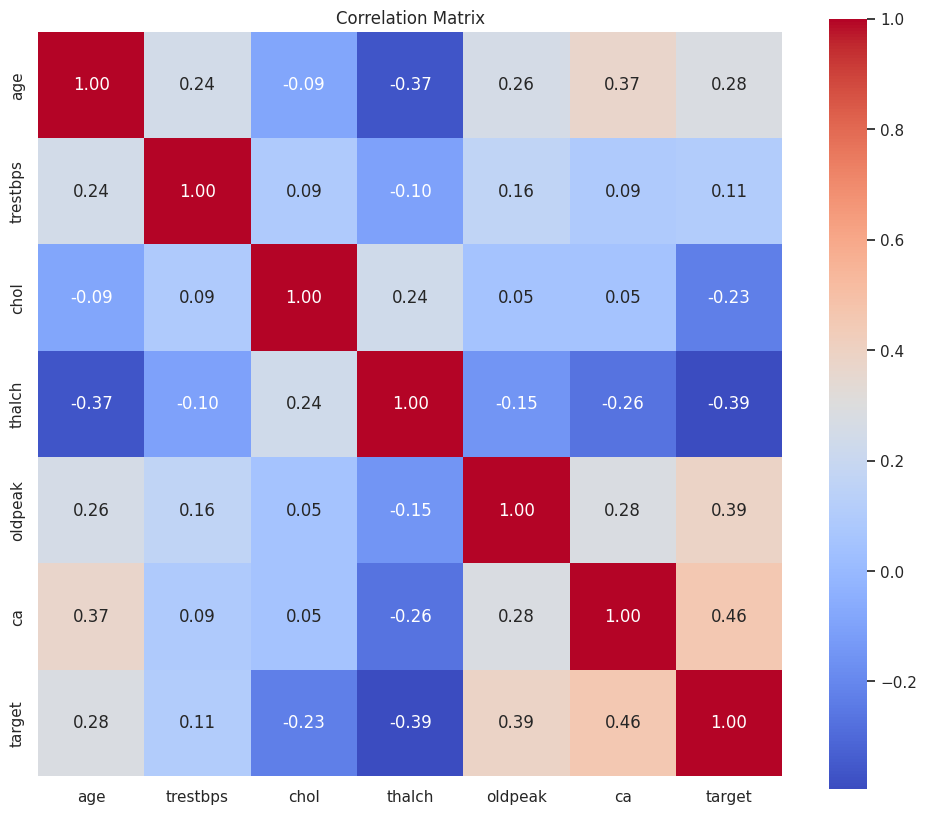

In [11]:
plt.figure(figsize=(12, 10))
# Select only numeric columns and drop 'id' and 'num' before calculating correlation
# 'num' is the original target, 'target' is the binarized one. 'id' is an identifier.
numeric_df_for_corr = df.select_dtypes(include=np.number).drop(columns=['id', 'num'], errors='ignore')
corr = numeric_df_for_corr.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

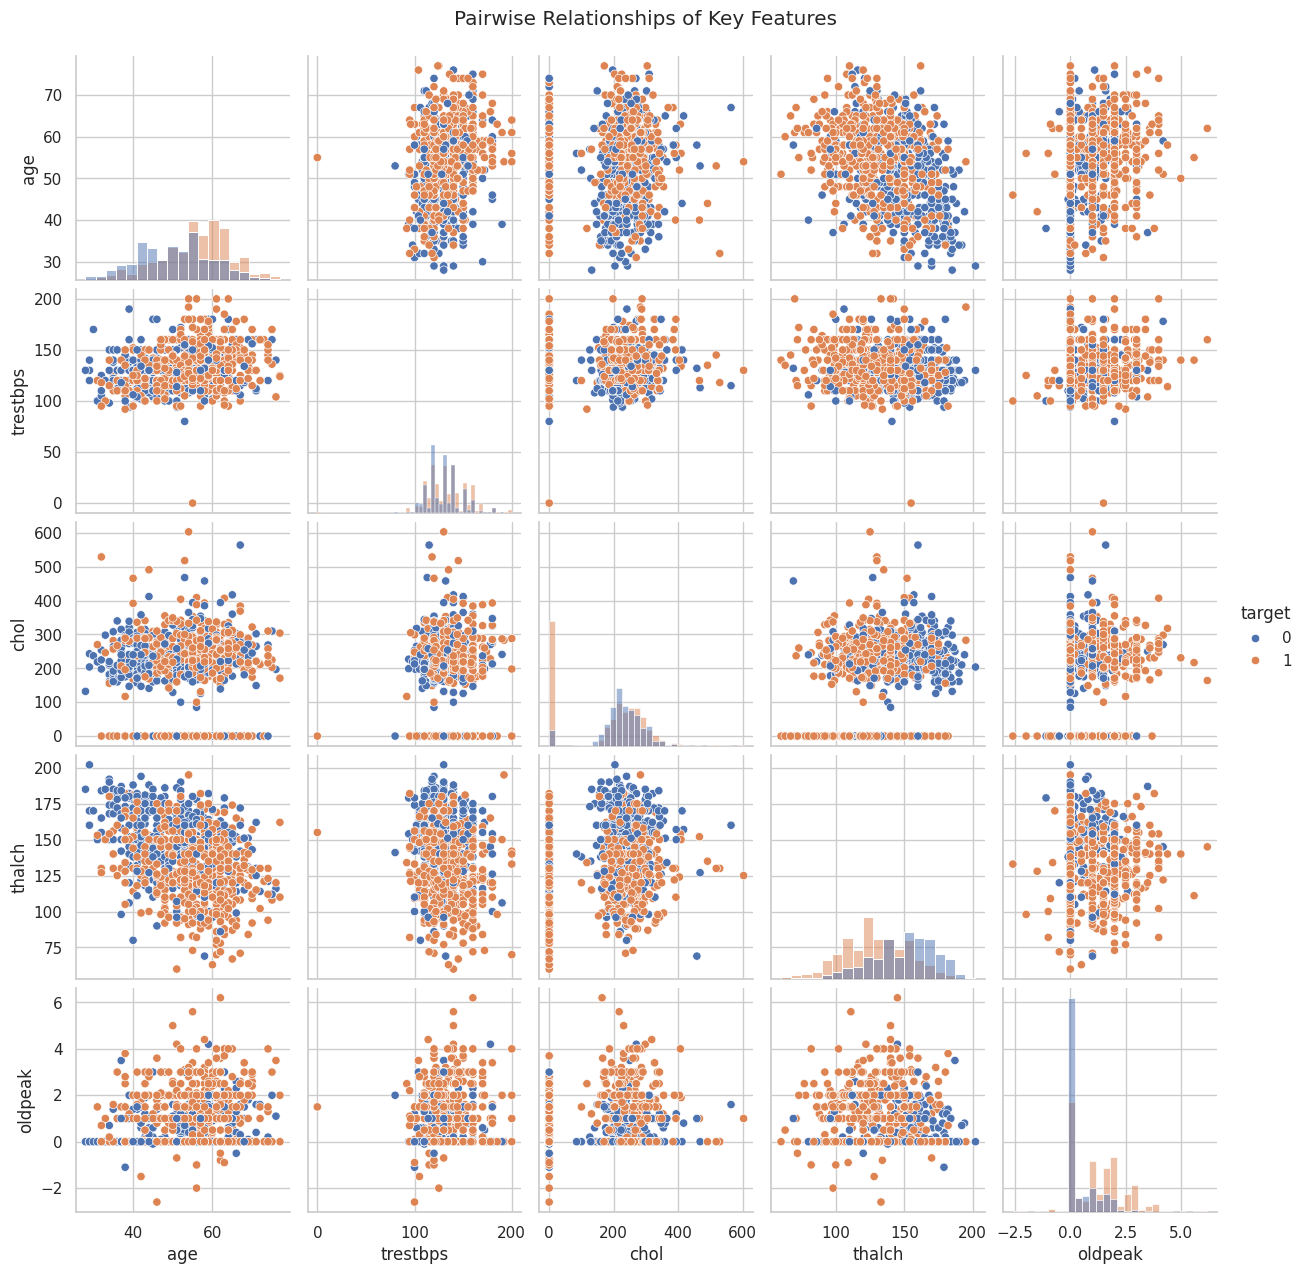

In [12]:
sns.pairplot(df[['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'target']], hue='target', diag_kind='hist')
plt.suptitle('Pairwise Relationships of Key Features', y=1.02)
plt.show()

## 6. Preprocessing & Stratified Split

### Preprocessing: Handle Missing Values & Encode Categorical Features

Before training, we need to ensure all features are numerical and that missing values are handled. We'll perform the following steps:
1. Drop irrelevant columns (`id`, `num`).
2. Impute missing numerical values with the median.
3. Impute missing categorical values with the mode.
4. Apply one-hot encoding to all categorical columns.

# Identify numerical and categorical columns


In [13]:
# Make a copy to avoid modifying the original DataFrame
df_processed = df.copy()

# Drop 'id' and 'num' (original target) columns
df_processed = df_processed.drop(columns=['id', 'num'])

# Separate features (X) and target (y)
X = df_processed.drop('target', axis=1)
y = df_processed['target']

# Identify numerical and categorical columns
numerical_cols_to_impute = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols_to_impute = X.select_dtypes(include='object').columns.tolist()

print(f"Numerical columns to impute: {numerical_cols_to_impute}")
print(f"Categorical columns to impute: {categorical_cols_to_impute}")

Numerical columns to impute: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Categorical columns to impute: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


# Impute missing numerical values with the median


In [14]:
# Impute missing numerical values with the median
for col in numerical_cols_to_impute:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col] = X[col].fillna(median_val)
        print(f"Imputed numerical column '{col}' with median: {median_val}")

Imputed numerical column 'trestbps' with median: 130.0
Imputed numerical column 'chol' with median: 223.0
Imputed numerical column 'thalch' with median: 140.0
Imputed numerical column 'oldpeak' with median: 0.5
Imputed numerical column 'ca' with median: 0.0


In [15]:
# Impute missing categorical values with the mode
for col in categorical_cols_to_impute:
    if X[col].isnull().any():
        mode_val = X[col].mode()[0] # .mode() can return multiple values, take the first
        X[col] = X[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode: {mode_val}")

Imputed categorical column 'fbs' with mode: False
Imputed categorical column 'restecg' with mode: normal
Imputed categorical column 'exang' with mode: False
Imputed categorical column 'slope' with mode: flat
Imputed categorical column 'thal' with mode: normal


/tmp/ipython-input-2189388434.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col] = X[col].fillna(mode_val)


In [16]:
# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_cols_to_impute, drop_first=True)

print("Shape of X after one-hot encoding:", X.shape)
display(X.head())

Shape of X after one-hot encoding: (920, 21)


,age,trestbps,chol,thalch,oldpeak,ca,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,...,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,63,145.0,233.0,150.0,2.3,0.0,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
1,67,160.0,286.0,108.0,1.5,3.0,True,False,False,False,...,False,False,False,False,False,True,True,False,True,False
2,67,120.0,229.0,129.0,2.6,2.0,True,False,False,False,...,False,False,False,False,False,True,True,False,False,True
3,37,130.0,250.0,187.0,3.5,0.0,True,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4,41,130.0,204.0,172.0,1.4,0.0,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


# Dataset split


In [17]:
X_train_val, X_test, y_train_val, y_test_labels = train_test_split(
    X.values, y.values, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
X_train, X_val, y_train_labels, y_val_labels = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=RANDOM_STATE
)

feature_names = X.columns.tolist()

X_train_unscaled = X_train.copy()
X_val_unscaled = X_val.copy()
X_test_unscaled = X_test.copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_unscaled)
X_val_scaled = scaler.transform(X_val_unscaled)
X_test_scaled = scaler.transform(X_test_unscaled)

X_train_scaled = X_train_scaled.astype('float32')
X_val_scaled = X_val_scaled.astype('float32')
X_test_scaled = X_test_scaled.astype('float32')

y_train_nn = y_train_labels.astype('float32')
y_val_nn = y_val_labels.astype('float32')
y_test_nn = y_test_labels.astype('float32')

print('Train shape (scaled):', X_train_scaled.shape)
print('Validation shape (scaled):', X_val_scaled.shape)
print('Test shape (scaled):', X_test_scaled.shape)

Train shape (scaled): (588, 21)
Validation shape (scaled): (148, 21)
Test shape (scaled): (184, 21)


## 7. Model Definitions & Training Utilities
We construct three neural-network variants that address the earlier overfitting issue via batch normalization, dropout, and L2 regularization:
- **Baseline MLP**: a compact network to establish a quick reference point.
- **Regularized MLP**: deeper architecture with heavier regularization to balance bias/variance.
- **Residual MLP**: introduces a skip connection to help gradients flow on tabular data.
The helper functions below also provide consistent plotting so we can diagnose training dynamics later.

In [28]:
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(exist_ok=True)

def build_baseline(input_dim: int) -> keras.Model:
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(24, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ], name='baseline_mlp')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def build_regularized(input_dim: int) -> keras.Model:
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(48, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.45),
        keras.layers.Dense(24, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.45),
        keras.layers.Dense(1, activation='sigmoid')
    ], name='regularized_mlp')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=2.5e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def build_residual(input_dim: int) -> keras.Model:
    inputs = keras.layers.Input(shape=(input_dim,), name='inputs')
    x = keras.layers.Dense(48, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3))(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.35)(x)
    residual = keras.layers.Dense(24, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3))(x)
    residual = keras.layers.BatchNormalization()(residual)
    residual = keras.layers.Dropout(0.35)(residual)
    x = keras.layers.concatenate([x, residual])
    x = keras.layers.Dense(24, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.35)(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name='residual_mlp')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=2.5e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_configs = [
    {
        'name': 'baseline_mlp',
        'builder': build_baseline,
        'epochs': 200,
        'batch_size': 28,
        'description': 'Compact MLP with strong dropout and L2 regularization.'
    },
    {
        'name': 'regularized_mlp',
        'builder': build_regularized,
        'epochs': 200,
        'batch_size': 28,
        'description': 'Deeper network with high dropout and L2 regularization.'
    },
    {
        'name': 'residual_mlp',
        'builder': build_residual,
        'epochs': 200,
        'batch_size': 28,
        'description': 'Residual-style connections with dropout and weight decay.'
    }
 ]

def plot_history(history: keras.callbacks.History, title: str) -> None:
    metrics = history.history
    epochs = np.arange(1, len(metrics['loss']) + 1)
    best_epoch = int(np.argmin(metrics['val_loss']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(epochs, metrics['loss'], label='Train Loss')
    axes[0].plot(epochs, metrics['val_loss'], label='Val Loss')
    axes[0].axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    axes[0].set_title(f'{title} - Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Binary Cross-Entropy')
    axes[0].legend()

    axes[1].plot(epochs, metrics['accuracy'], label='Train Accuracy')
    axes[1].plot(epochs, metrics['val_accuracy'], label='Val Accuracy')
    axes[1].axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    axes[1].set_title(f'{title} - Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.show()

## 8. Training Loop
Run this cell to train the neural networks with early stopping, learning-rate reduction, and checkpointing. The callbacks keep the best weights, so the validation metrics you see later reflect the strongest epoch rather than the final one.

In [29]:
histories: Dict[str, keras.callbacks.History] = {}
results: List[Dict[str, float]] = []
predictions: Dict[str, np.ndarray] = {}
probabilities: Dict[str, np.ndarray] = {}
model_display_order: List[str] = []

for cfg in model_configs:
    name = cfg['name']
    print(f"\nTraining {name}...")
    model = cfg['builder'](X_train_scaled.shape[1])
    checkpoint_path = MODELS_DIR / f"{name}_best.weights.h5"

    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=0
        ),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
    ]

    history = model.fit(
        X_train_scaled, y_train_nn,
        validation_data=(X_val_scaled, y_val_nn),
        epochs=cfg['epochs'],
        batch_size=cfg['batch_size'],
        verbose=1,
        callbacks=callbacks
    )
    histories[name] = history

    test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_nn, verbose=0)
    y_prob = model.predict(X_test_scaled, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    roc_auc = roc_auc_score(y_test_labels, y_prob)
    precision = precision_score(y_test_labels, y_pred)
    recall = recall_score(y_test_labels, y_pred)
    f1 = f1_score(y_test_labels, y_pred)
    best_val_epoch = int(np.argmin(history.history['val_loss']) + 1)
    best_val_loss = float(np.min(history.history['val_loss']))
    best_val_accuracy = float(np.max(history.history['val_accuracy']))

    results.append({
        'model': name,
        'type': 'neural_net',
        'description': cfg['description'],
        'best_val_epoch': best_val_epoch,
        'best_val_loss': best_val_loss,
        'best_val_accuracy': best_val_accuracy,
        'test_accuracy': float(test_accuracy),
        'test_loss': float(test_loss),
        'roc_auc': float(roc_auc),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    })

    predictions[name] = y_pred
    probabilities[name] = y_prob
    model_display_order.append(name)

    print(classification_report(y_test_labels, y_pred))


Training baseline_mlp...
Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6405 - loss: 0.7043 - val_accuracy: 0.6689 - val_loss: 0.6382 - learning_rate: 3.0000e-04
Epoch 2/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6502 - loss: 0.6813 - val_accuracy: 0.7230 - val_loss: 0.6097 - learning_rate: 3.0000e-04
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6953 - loss: 0.6355 - val_accuracy: 0.7365 - val_loss: 0.5854 - learning_rate: 3.0000e-04
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7062 - loss: 0.6292 - val_accuracy: 0.7500 - val_loss: 0.5646 - learning_rate: 3.0000e-04
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7700 - loss: 0.5834 - val_accuracy: 0.7432 - val_loss: 0.5476 - learning_rate: 3.0000e-04
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7276 - loss: 0.5974 - val_accuracy: 0.7568 - val_loss: 0.5348 - learning_rate: 3.0000e-04
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8

## 9. Neural Network Learning Curves
Visualize the learning dynamics for each neural architecture after applying regularization and early stopping.

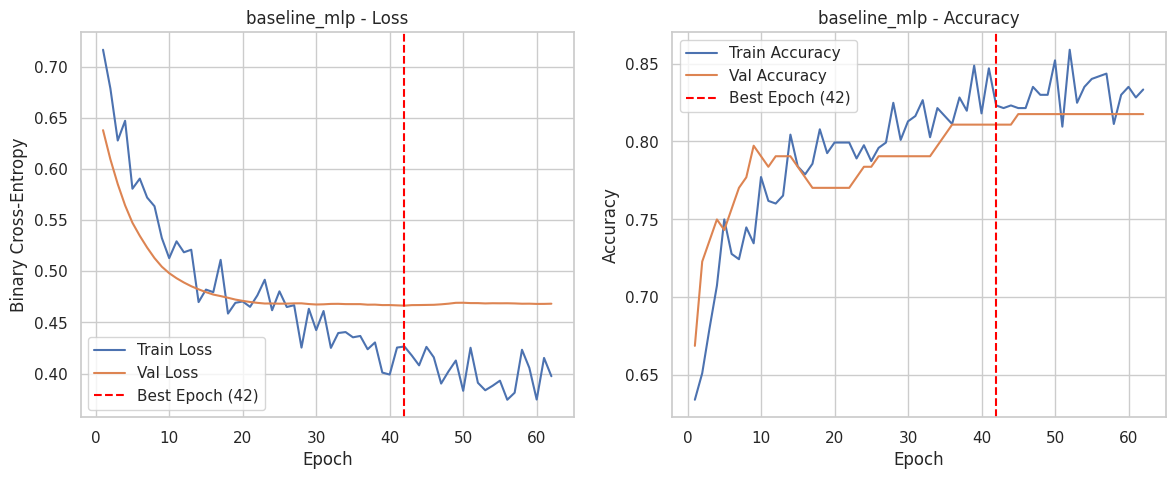

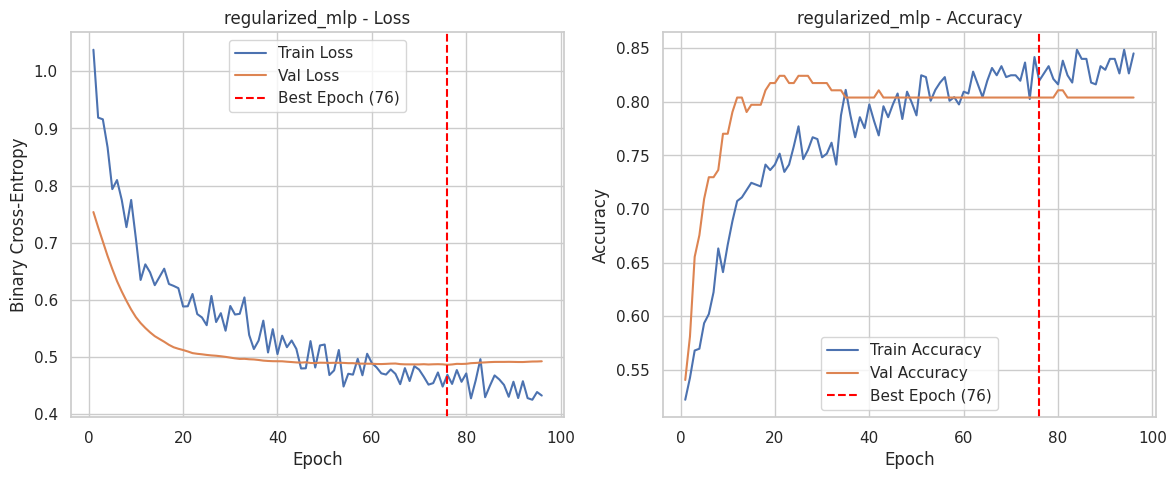

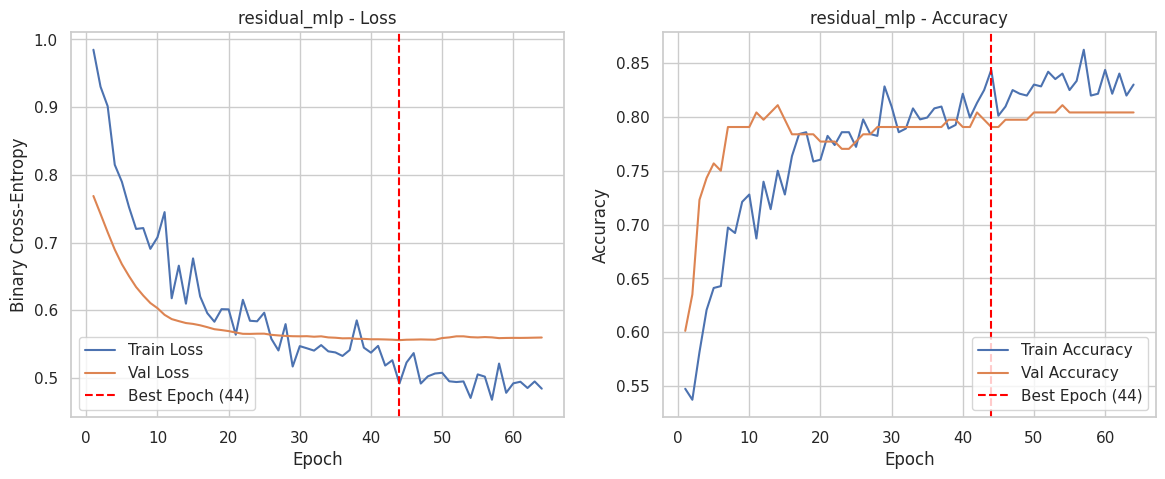

In [30]:
for name, history in histories.items():
    plot_history(history, title=name)

## 10. Tree & Classical Baselines
Train strong non-neural baselines to benchmark the neural networks and provide better generalization on small tabular datasets.

In [32]:
tree_model_configs = [
    {
        'name': 'logistic_regression',
        'description': 'L2-regularized logistic regression baseline.',
        'model': LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
        'use_scaled': True
    },
    {
        'name': 'random_forest',
        'description': 'Random forest with depth control for interpretability.',
        'model': RandomForestClassifier(
            n_estimators=1000, max_depth=8, min_samples_leaf=2, random_state=RANDOM_STATE, n_jobs=-1
        ),
        'use_scaled': False
    },
    {
        'name': 'gradient_boosting',
        'description': 'Gradient boosting classifier tuned for tabular data.',
        'model': GradientBoostingClassifier(
            learning_rate=0.05, n_estimators=600, max_depth=3, random_state=RANDOM_STATE
        ),
        'use_scaled': False
    },
    {
        'name': 'xgboost',
        'description': 'XGBoost with subsampling to reduce overfitting.',
        'model': XGBClassifier(
            n_estimators=600, learning_rate=0.05, max_depth=4, subsample=0.9, colsample_bytree=0.9,
            reg_lambda=1.0, random_state=RANDOM_STATE, eval_metric='logloss', n_jobs=-1
        ),
        'use_scaled': False
    }
 ]

for cfg in tree_model_configs:
    name = cfg['name']
    print(f"\nTraining {name}...")
    model = cfg['model']
    train_X = X_train_scaled if cfg['use_scaled'] else X_train_unscaled
    val_X = X_val_scaled if cfg['use_scaled'] else X_val_unscaled
    test_X = X_test_scaled if cfg['use_scaled'] else X_test_unscaled

    model.fit(train_X, y_train_labels)
    y_val_pred = model.predict(val_X)
    val_accuracy = accuracy_score(y_val_labels, y_val_pred)

    y_test_pred = model.predict(test_X)
    if hasattr(model, "predict_proba"):
        y_test_prob = model.predict_proba(test_X)[:, 1]
    elif hasattr(model, "decision_function"):
        decision_scores = model.decision_function(test_X)
        y_test_prob = 1.0 / (1.0 + np.exp(-decision_scores))
    else:
        y_test_prob = y_test_pred.astype(float)

    y_test_prob = np.clip(y_test_prob, 1e-7, 1 - 1e-7)
    test_accuracy = accuracy_score(y_test_labels, y_test_pred)
    test_loss = log_loss(y_test_labels, y_test_prob)
    roc_auc = roc_auc_score(y_test_labels, y_test_prob)
    precision = precision_score(y_test_labels, y_test_pred)
    recall = recall_score(y_test_labels, y_test_pred)
    f1 = f1_score(y_test_labels, y_test_pred)

    results.append({
        'model': name,
        'type': 'classical',
        'description': cfg['description'],
        'best_val_epoch': np.nan,
        'best_val_loss': np.nan,
        'best_val_accuracy': float(val_accuracy),
        'test_accuracy': float(test_accuracy),
        'test_loss': float(test_loss),
        'roc_auc': float(roc_auc),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    })

    predictions[name] = y_test_pred
    probabilities[name] = y_test_prob
    model_display_order.append(name)

    print(classification_report(y_test_labels, y_test_pred))


Training logistic_regression...
              precision    recall  f1-score   support

           0       0.86      0.78      0.82        82
           1       0.84      0.90      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184


Training random_forest...
              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184


Training gradient_boosting...
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        82
           1       0.83      0.91      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84    

## 11. Confusion Matrices
Compare the distribution of true/false positives and negatives across every trained model using the same test set.

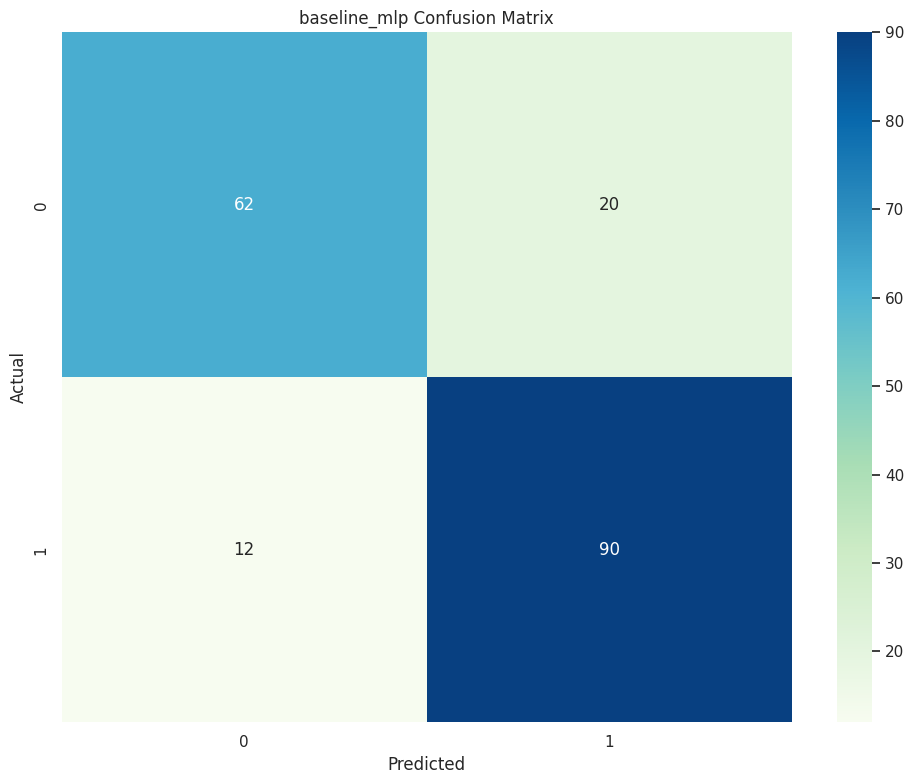

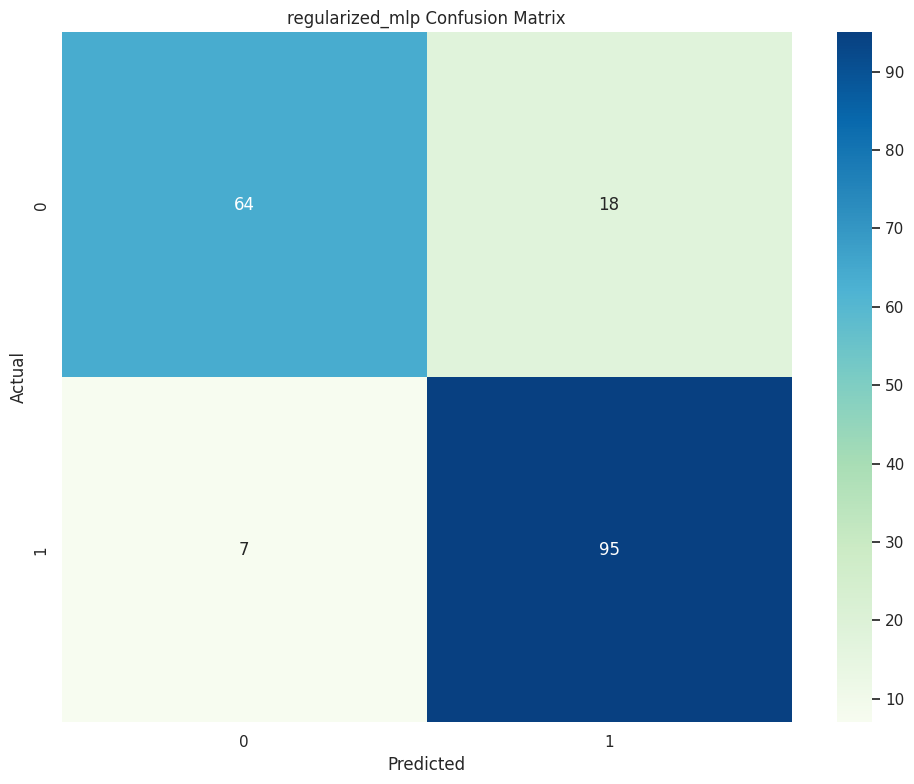

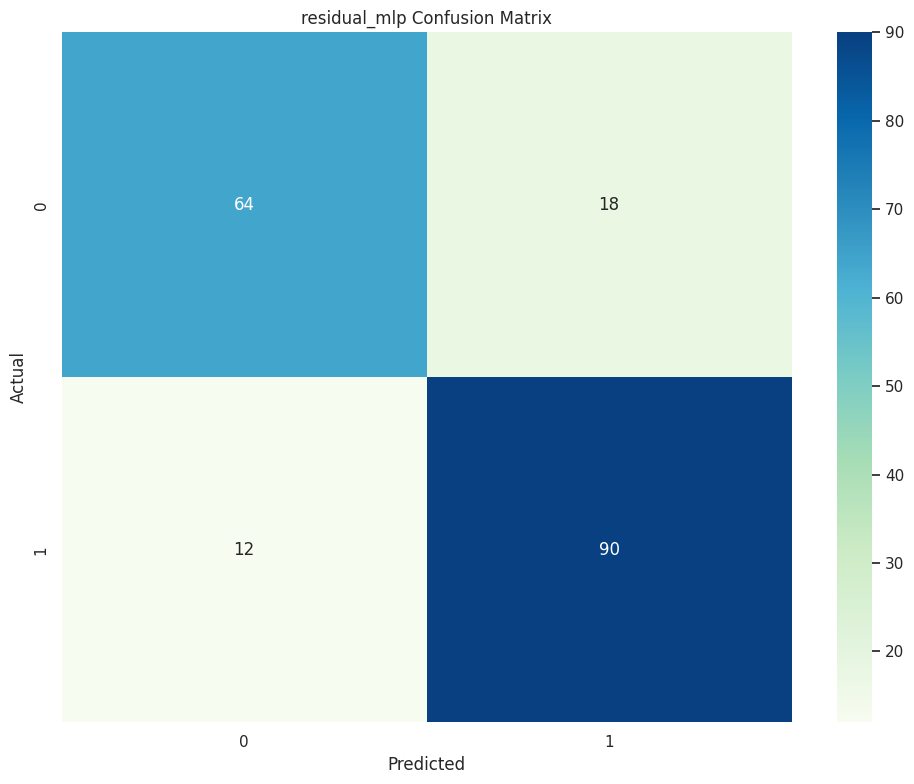

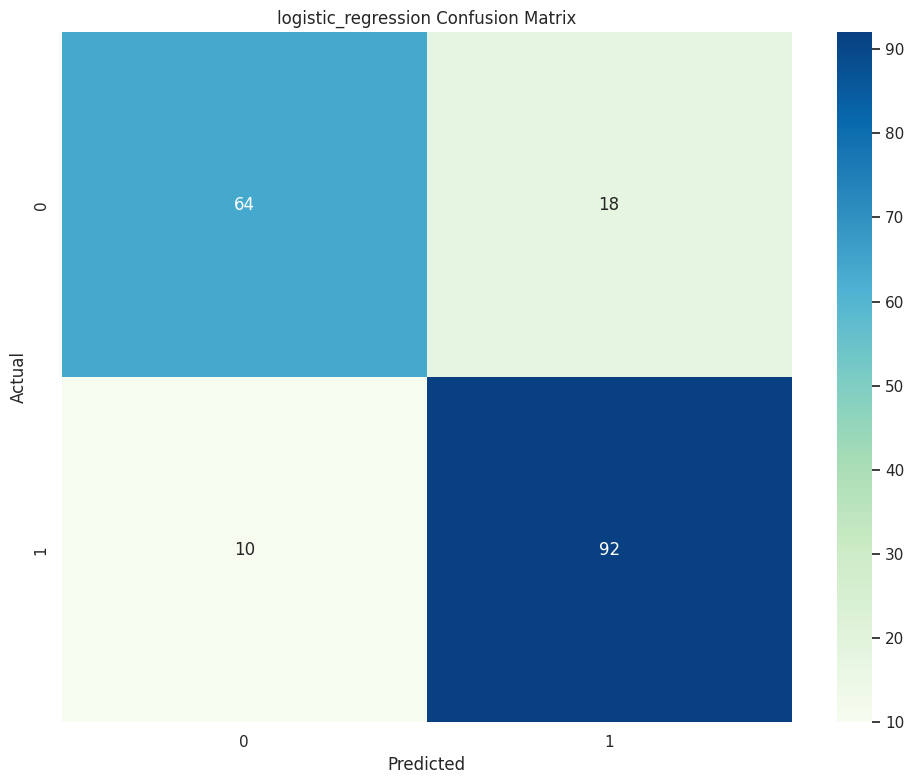

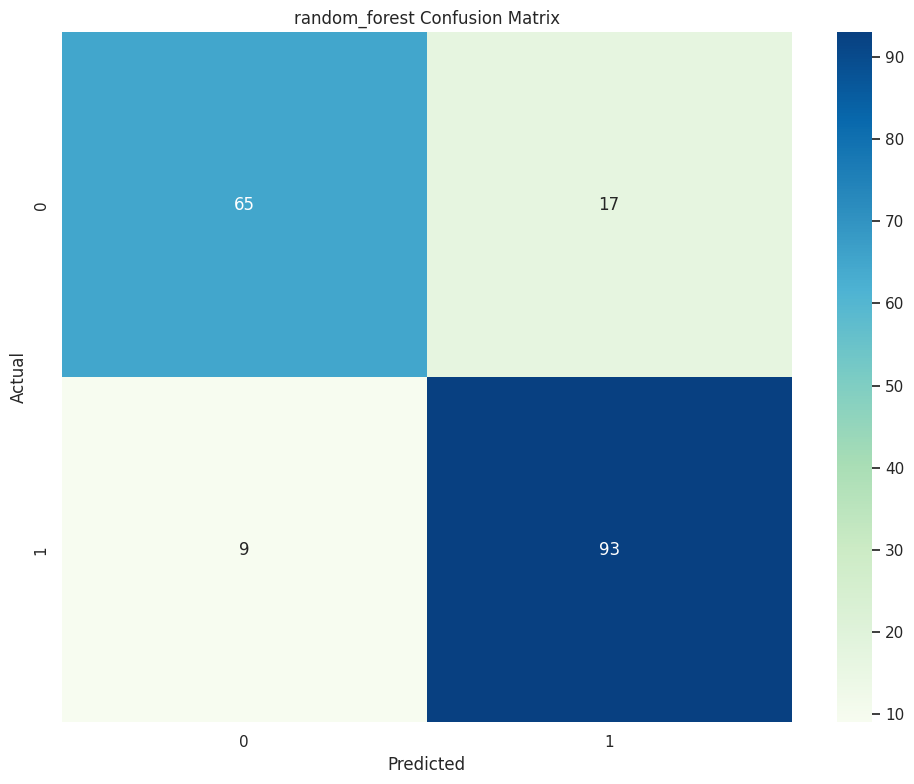

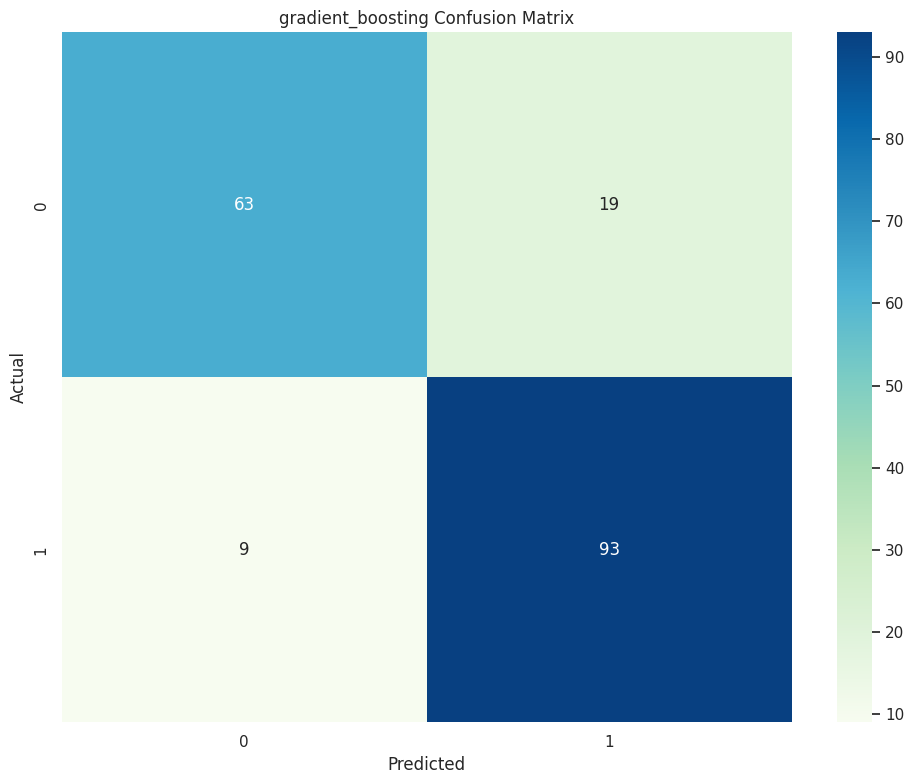

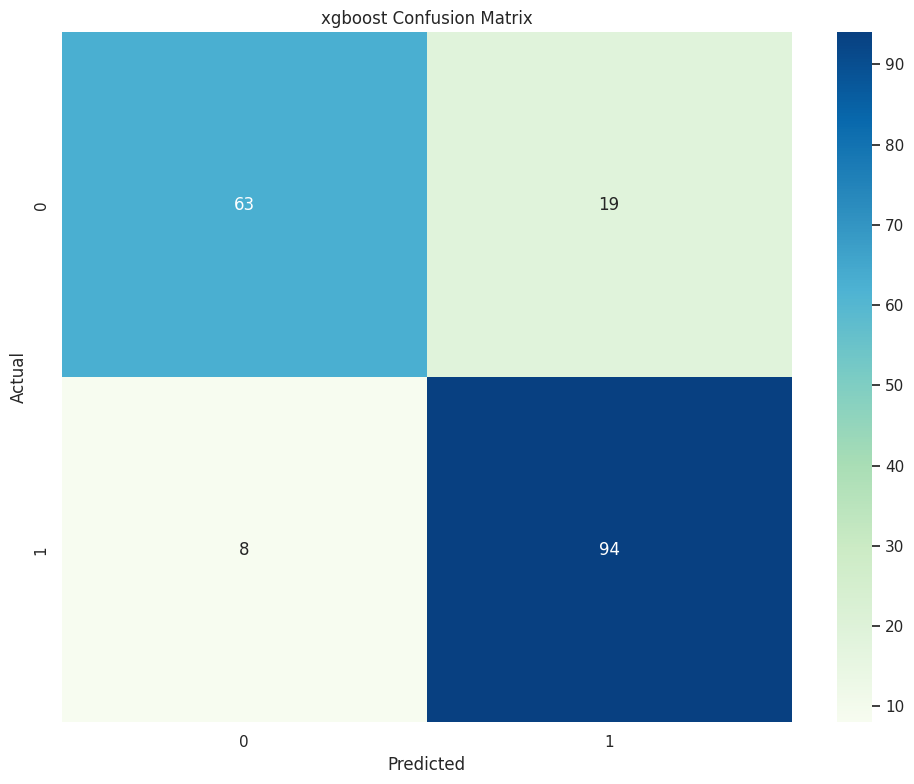

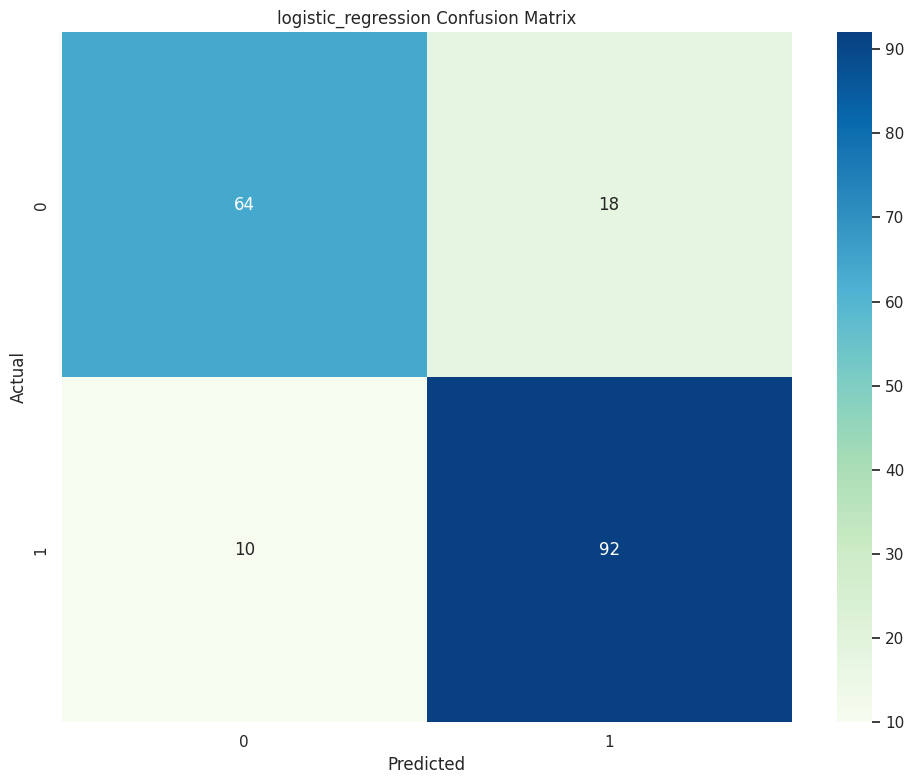

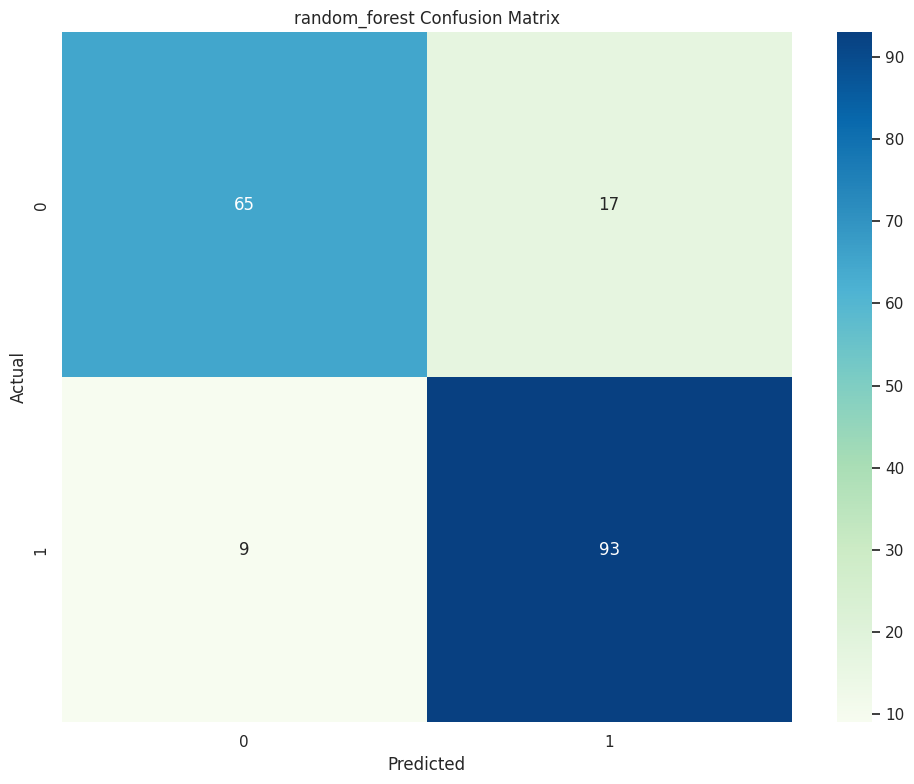

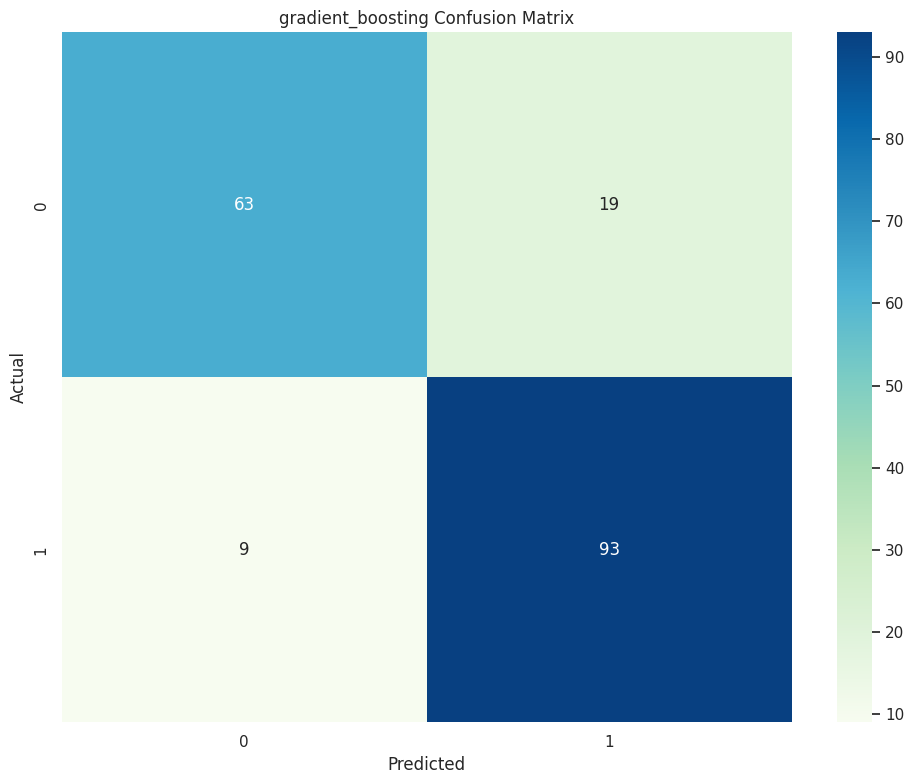

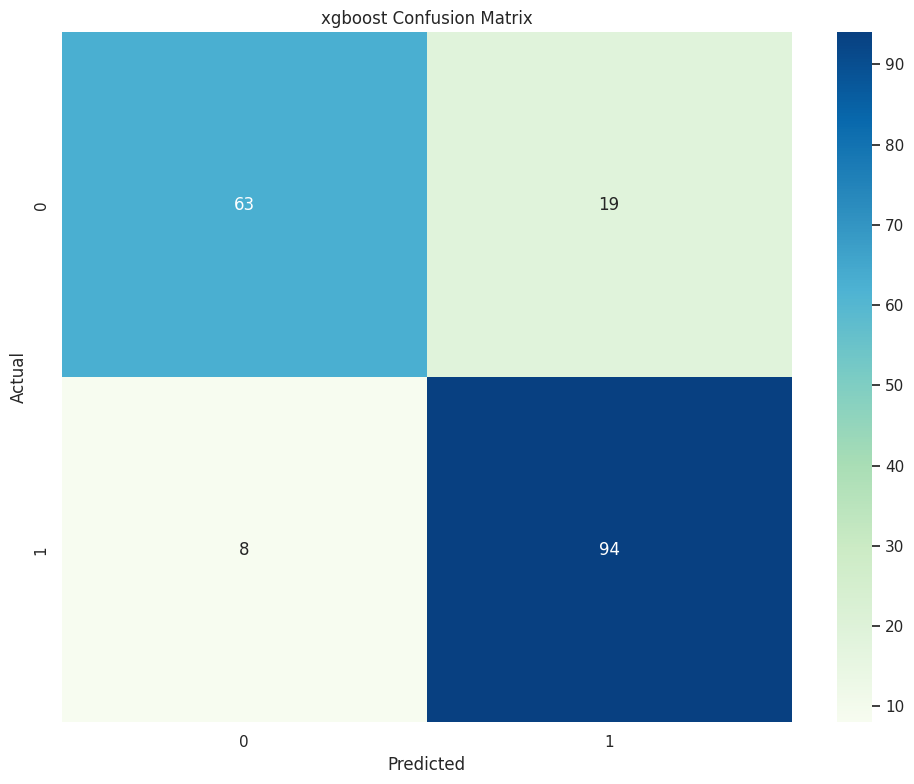

In [37]:
if not model_display_order:
    raise ValueError("No models have been trained yet. Run the training cells above first.")

for name in model_display_order:
    fig, ax = plt.subplots(figsize=(10, 8)) # Create a new figure and axis for each matrix, adjusted for 'big'
    cm = confusion_matrix(y_test_labels, predictions[name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', ax=ax) # Changed cmap to 'GnBu' for teal-like colors
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.tight_layout() # Ensure layout is tight for each figure
    plt.show() # Display each figure individually

# Confusion matrix for the best model

Displaying confusion matrix for the best model: gradient_boosting


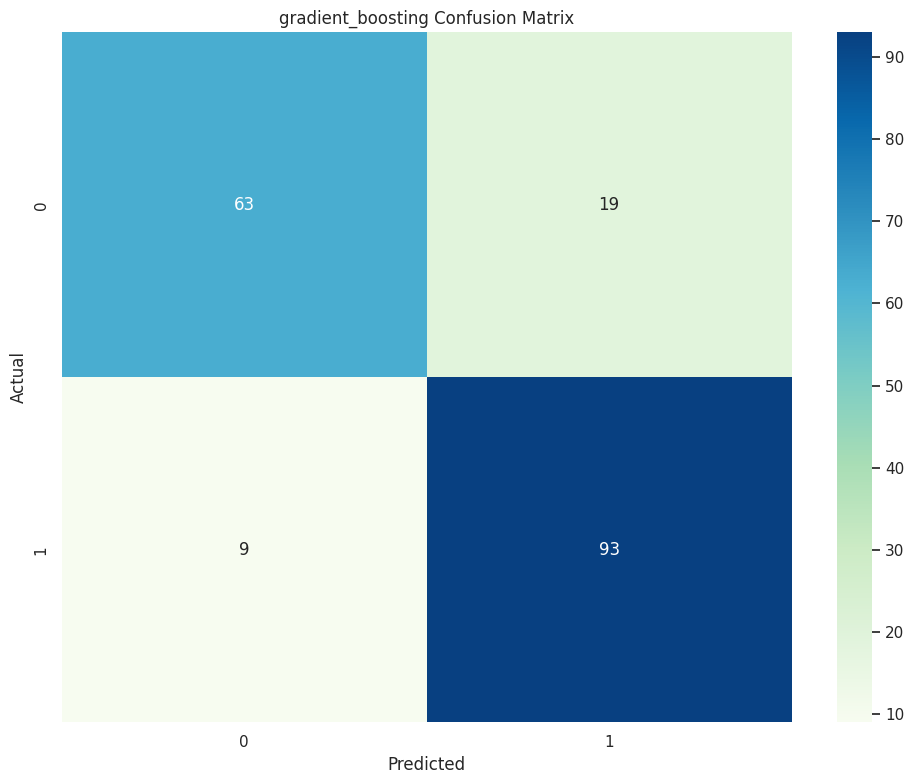

In [46]:
if results_df.empty:
    raise ValueError("Results dataframe is empty. Ensure models have been trained before summarizing.")

best_model_name = results_df.iloc[0]['model']

print(f"Displaying confusion matrix for the best model: {best_model_name}")

fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_test_labels, predictions[best_model_name])
sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu', ax=ax)
ax.set_title(f'{best_model_name} Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

## 12. ROC Curves
Visualize the trade-off between sensitivity and specificity. Higher AUC traces indicate better separability.

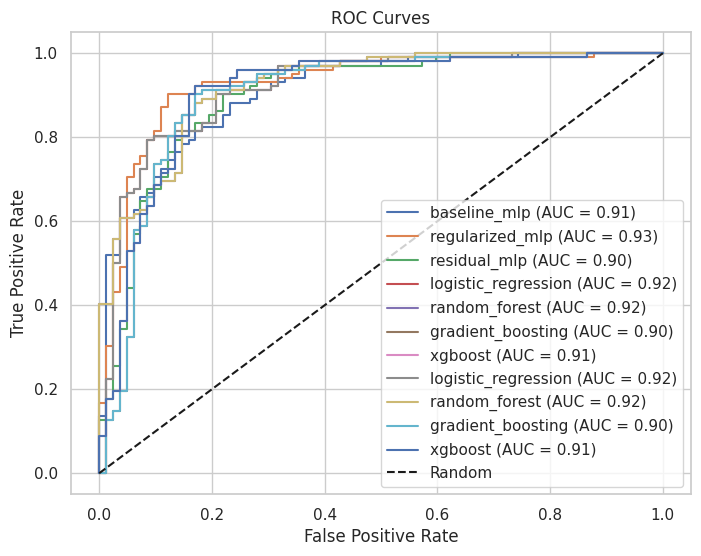

In [35]:
plt.figure(figsize=(8, 6))
for name in model_display_order:
    if name not in probabilities:
        continue
    fpr, tpr, _ = roc_curve(y_test_labels, probabilities[name])
    roc_auc_val = roc_auc_score(y_test_labels, probabilities[name])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid(True)
plt.show()

## 13. Consolidated Results Table
Sorts all neural and tree-based models by test accuracy so you can quickly identify which configuration generalizes best.

In [41]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('test_accuracy', ascending=False).reset_index(drop=True)
columns_to_display = ['model', 'type', 'description', 'best_val_accuracy', 'test_accuracy', 'test_loss', 'roc_auc', 'precision', 'recall', 'f1']
display(results_df[columns_to_display])

,model,type,description,best_val_accuracy,test_accuracy,test_loss,roc_auc,precision,recall,f1
0,gradient_boosting,classical,Gradient boosting classifier tuned for tabular...,0.790541,0.880435,0.396951,0.906145,0.870370,0.921569,0.895238
1,xgboost,classical,XGBoost with subsampling to reduce overfitting.,0.804054,0.875000,0.378112,0.913319,0.849558,0.941176,0.893023
2,regularized_mlp,neural_net,Deeper network with high dropout and L2 regula...,0.824324,0.864130,0.398445,0.927188,0.840708,0.931373,0.883721
3,random_forest,classical,Random forest with depth control for interpret...,0.797297,0.858696,0.371369,0.922047,0.845455,0.911765,0.877358
4,random_forest,classical,Random forest with depth control for interpret...,0.804054,0.858696,0.370859,0.921688,0.845455,0.911765,0.877358
5,xgboost,classical,XGBoost with subsampling to reduce overfitting.,0.804054,0.853261,0.417875,0.906982,0.831858,0.921569,0.874419
6,logistic_regression,classical,L2-regularized logistic regression baseline.,0.817568,0.847826,0.370947,0.917025,0.836364,0.901961,0.867925
7,logistic_regression,classical,L2-regularized logistic regression baseline.,0.817568,0.847826,0.370947,0.917025,0.836364,0.901961,0.867925
8,gradient_boosting,classical,Gradient boosting classifier tuned for tabular...,0.797297,0.847826,0.437041,0.900048,0.830357,0.911765,0.869159
9,residual_mlp,neural_net,Residual-style connections with dropout and we...,0.810811,0.836957,0.486717,0.900526,0.833333,0.882353,0.857143


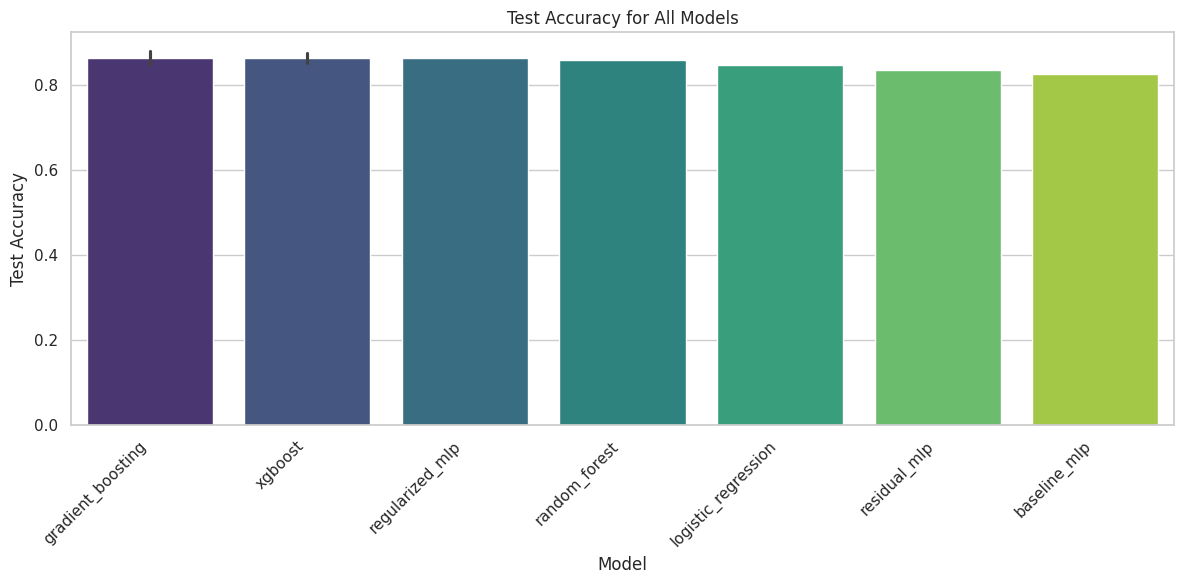

In [43]:
plt.figure(figsize=(12, 6))
sns.barplot(x='model', y='test_accuracy', data=results_df, palette='viridis', hue='model', legend=False)
plt.title('Test Accuracy for All Models')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Best Model Snapshot

In [40]:
if results_df.empty:
    raise ValueError("Results dataframe is empty. Ensure models have been trained before summarizing.")

best_row = results_df.iloc[0]
print(f"Best model: {best_row['model']} ({best_row['description']})")
print(f" - Test Accuracy: {best_row['test_accuracy']:.4f}")
print(f" - ROC AUC: {best_row['roc_auc']:.4f}")
print(f" - Precision: {best_row['precision']:.4f}")
print(f" - Recall: {best_row['recall']:.4f}")
print(f" - F1 Score: {best_row['f1']:.4f}")
if not np.isnan(best_row['best_val_accuracy']):
    print(f" - Best Validation Accuracy: {best_row['best_val_accuracy']:.4f}")

Best model: gradient_boosting (Gradient boosting classifier tuned for tabular data.)
 - Test Accuracy: 0.8804
 - ROC AUC: 0.9061
 - Precision: 0.8704
 - Recall: 0.9216
 - F1 Score: 0.8952
 - Best Validation Accuracy: 0.7905
